In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Display the first few rows of each dataset
print("Customers Dataset")
print(customers.head())

print("\nProducts Dataset")
print(products.head())

print("\nTransactions Dataset")
print(transactions.head())


Customers Dataset
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Dataset
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Dataset
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      

In [5]:
# Merge transactions with customers and products
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Create aggregated features for customers
customer_profiles = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total revenue generated by the customer
    'Quantity': 'sum',    # Total quantity of products bought
    'Category': lambda x: x.mode()[0],  # Most common product category purchased
    'Region': 'first',    # Customer's region
}).reset_index()

print("Customer Profiles:")
print(customer_profiles.head())


Customer Profiles:
  CustomerID  TotalValue  Quantity     Category         Region
0      C0001     3354.52        12  Electronics  South America
1      C0002     1862.74        10     Clothing           Asia
2      C0003     2725.38        14   Home Decor  South America
3      C0004     5354.88        23        Books  South America
4      C0005     2034.24         7  Electronics           Asia


In [6]:
# One-hot encode 'Region' and 'Category'
customer_profiles_encoded = pd.get_dummies(customer_profiles, columns=['Region', 'Category'], drop_first=True)

print("Encoded Customer Profiles:")
print(customer_profiles_encoded.head())


Encoded Customer Profiles:
  CustomerID  TotalValue  Quantity  Region_Europe  Region_North America  \
0      C0001     3354.52        12              0                     0   
1      C0002     1862.74        10              0                     0   
2      C0003     2725.38        14              0                     0   
3      C0004     5354.88        23              0                     0   
4      C0005     2034.24         7              0                     0   

   Region_South America  Category_Clothing  Category_Electronics  \
0                     1                  0                     1   
1                     0                  1                     0   
2                     1                  0                     0   
3                     1                  0                     0   
4                     0                  0                     1   

   Category_Home Decor  
0                    0  
1                    0  
2                    1  
3            

In [7]:
from sklearn.preprocessing import StandardScaler

# Use the encoded customer profiles for clustering
X = customer_profiles_encoded.drop(columns=['CustomerID'])

# Standardize the data for better clustering performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data Ready for Clustering")


Data Ready for Clustering


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Test clustering with different numbers of clusters
db_scores = []
clusters_range = range(2, 11)

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    db_score = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db_score)
    print(f"Number of Clusters: {k}, DB Index: {db_score:.2f}")

# Find the best number of clusters (lowest DB Index)
optimal_k = clusters_range[db_scores.index(min(db_scores))]
print(f"\nOptimal Number of Clusters: {optimal_k}")

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(X_scaled)


Number of Clusters: 2, DB Index: 2.17
Number of Clusters: 3, DB Index: 1.76
Number of Clusters: 4, DB Index: 1.56
Number of Clusters: 5, DB Index: 1.44
Number of Clusters: 6, DB Index: 1.32
Number of Clusters: 7, DB Index: 1.32
Number of Clusters: 8, DB Index: 1.17
Number of Clusters: 9, DB Index: 1.18
Number of Clusters: 10, DB Index: 1.15

Optimal Number of Clusters: 10


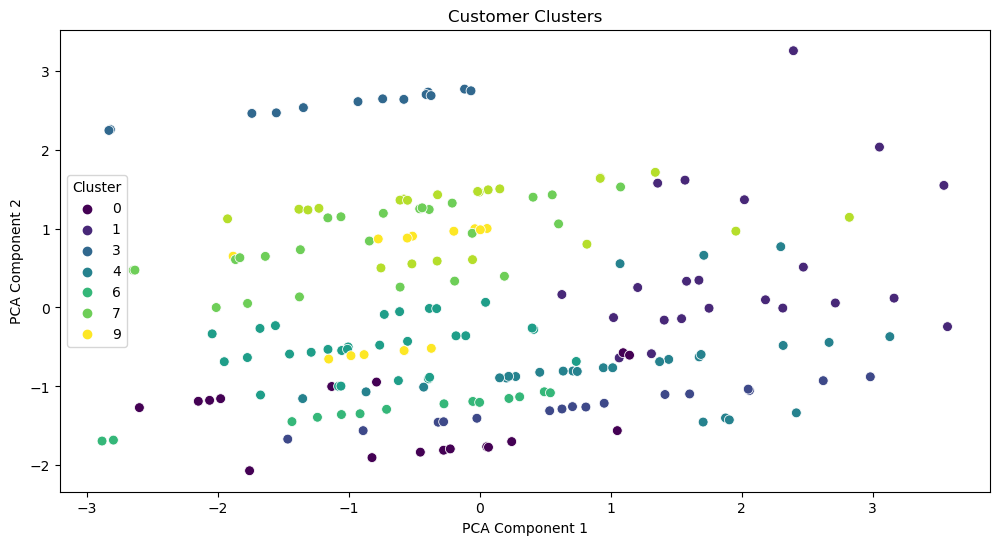

In [9]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot of the clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=customer_profiles['Cluster'], palette='viridis', s=50)
plt.title("Customer Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()
